# Transmitting FT8

This notebook demonstrates how WSJT-X transmits FT8 signals.

It uses the following Python libraries:

In [1]:
import numpy as np
import scipy.io.wavfile
import ft8
import matplotlib.pyplot as plt
import scipy.signal
import scipy.special

## Overview

The following diagram illustrates the major processing steps required to transmit FT8 signals.

![Transmit Overview](drawings/Transmit.svg)

Each of the these processing steps are described in more detail below.

## Message Packing

The first step in the transmission of FT8 signals is message packing.
Message packing is a form of data compression, which is also known as **source encoding** in the information
theory literature.

The FT8 digital mode uses a unique message packing scheme that was developed by Dr. Joe Taylor (K1JT), who is
the lead developer of WSJT-X.
It is similar (but not identical) to the message packing methods he used in earlier digital modes such as JT65.

The FT8 digital mode requires messages to conform to specific standards so they can be efficiently packed into
as few bits as possible.
These standards and the associated packing methods are described in detail in the [FT8 Packing](Packing.ipynb)
notebook.

All FT8 messages are packed into a total of $77$ bits, with the last $3$ bits denoting the message type.
This is illustrated below for messages of type 1, which is by far the most common message type used outside
contests.

![Standard Message](drawings/Standard%20Message.svg)

In this notebook, message packing is performed when creating objects of any sub-class of the Python
`ft8.Message` class.
The packed message is available as the `pack77` attribute of such objects.

The following example shows how classes in the `ft8` Python module can be used to create messages and pack them into 77 bits.

In [2]:
callsign_1 = ft8.Callsign('VK1ABC')
print(callsign_1, bin(callsign_1.pack28))
callsign_2 = ft8.Callsign('VK3JPK')
print(callsign_2, bin(callsign_2.pack28))
report = ft8.LocationReport('QF22')
print(report, bin(report.pack15))
msg = ft8.StandardMessage(callsign_1, callsign_2, report)
print(msg, bin(msg.pack77))

VK1ABC 0b1110000111111100010100110101
VK3JPK 0b1110001000000111101000011110
QF22 0b111001010001010
StandardMessage(VK1ABC VK3JPK QF22) 0b11100001111111000101001101010111000100000011110100001111000111001010001010001


## Cyclic Redudancy Check Encoding

FT8 uses a cyclic redundancy check (CRC) code to detect errors that cannot be corrected by the FT8 forward
error correction code.

CRC codes are generated using polynomial division modulo 2.
The message bits (after padding with some trailing zeros) are used as the coefficients of a polynomial,
and the remainder of dividing that polynomial (modulo 2) by a specific polynomial is the CRC code
for that message.

The CRC encoding used by FT8 has the following polynomial divisor:

$$x^{14}+x^{13}+x^{10}+x^9+x^8+x^6+x^4+x^2+x^1+1$$

The resulting CRC code is 14 bits long.
This code is appended to the packed message before subsequent codes are applied.
The packed message with appended CRC code is therefore 91 bits.

In this notebook the CRC code is calculated by the `_crc` function of the `ft8.Message` class.

In [3]:
crc = ft8.Message._crc(msg.pack77, 0)
print(bin(crc))

0b111100110010


## Low-Density Parity-Check Encoding

FT8 uses a low-density parity-check (LDPC) code for forward error correction.

LDPC encoding is peformed by performing matrix multiplication (modulo 2) of a generator matrix and a column vector that is based on the message bits.
The generator matrix has a number of columns equal to the number of message bits.
The generator matrix has a number of rows equal to the number of parity bits in the code.
The parity bits calculated by the matrix multiplication are appended to the message bits
to create the complete LDPC codeword as illustrated below:

![LDPC Encoding](drawings/LDPC%20Encoding.svg)

The generator matrix used for the FT8 digital mode has $91$ columns and $83$ rows
and is used to generate $83$ parity bits from $91$ bits, comprised of a $77$ bit message
with appended $14$ bit CRC code.
The resulting LDPC codeword has $91 + 83 = 174$ bits.
The FT8 LDPC code generator matrix is defined in the `lib/ft8/ldpc_174_91_c_generator.f90` compilation unit
of the WSJT-X source code.

Matrix multiplication involves both multiplication and addition operations.
Matrix multiplication modulo 2 is performed by using the logical AND operator to perform
multiplications, and the logical XOR operation to perform additions.

Sometimes it is easier to perform the logical XOR operations by counting bits and returning zero
if the number of bits is even and one if the number of bits is odd.
The `ft8` Python module uses this method.

## Symbol Formation and Gray Encoding

The FT8 digital mode uses M-ary Gaussian frequency shift keying (M-GFSK) modulation where $M = 8$.
This requires that the bits to be transmitted are partitioned into groups of three bits to form
symbols.
In the FT8 digital mode, the $174$ bits in each LDPC codeword are partitioned into $58$ groups of
three bits to form $58$ symbols.
Each symbol has eight possible values based on the three bits used to construct the symbol.

Gray encoding is then applied to these symbols prior to modulation to improve the capability
of the receiver to demap the output of the demodulator into individual bits with minimal error.

Gray coding is a simple permutation of the eight possible symbols, named after Frank Gray who proposed
its use in early PCM digital communication systems as part of a 1948 patent application.
The Gray coding used by the FT8 digital mode is defined in the `lib/....` compilation unit of the WSJT-X
source code and is illustrated below:

![Gray Encoding](drawings/Gray%20Encoding.svg)

## Costas Arrays

Prior to modulation, the Gray encoded symbols are augmented with three seventh order Costas arrays.
These are inserted at the beginning, middle and end of the sequence of Gray encoded symbols,
to create a final sequence of 79 symbols inclusive of the Costas arrays.
This is illustrated in the following diagram:

![Costas Arrays](drawings/Costas%20Arrays.svg)

Costas arrays are inserted into the transmitted symbol sequence to enable the FT8 receiver to accurately
determine the frequency and time offset of each FT8 signal.

## Complete Encoding Chain

The complete encoding chain is implemented in this notebook by the `encode` method of the `ft8.Message` class,
which performs the following tasks:

1. Append the 14 bit CRC code to the 77 bit packed message yielding 91 bits
1. Calculate and append the 83 LDPC code parity bits yielding a 179 bit LDPC codeword
1. Form 58 symbols from the 179 bit LDPC codeword and apply Gray encoding
1. Insert Costas arrays to get the final sequence of 79 symbols

The following example encodes a message to generate the sequence of encoded symbols.

In [4]:
print(msg)
symbols = msg.encode()
print(symbols)

StandardMessage(VK1ABC VK3JPK QF22)
[3, 1, 4, 0, 6, 5, 2, 7, 0, 2, 7, 4, 1, 3, 2, 3, 6, 4, 1, 0, 0, 7, 6, 0, 2, 4, 1, 4, 3, 5, 3, 5, 3, 2, 4, 2, 3, 1, 4, 0, 6, 5, 2, 1, 1, 6, 3, 7, 4, 6, 4, 0, 2, 7, 7, 3, 5, 6, 4, 2, 2, 5, 4, 3, 0, 0, 0, 2, 5, 3, 0, 1, 3, 1, 4, 0, 6, 5, 2]


## Modulation Waveform

The sequence of encoded symbols (including Costas arrays) is used to create a waveform for frequency modulating
the transmitter carrier.

For WSJT-X version 2.0, M-FSK modulation is used and the sequence of encoded symbols is directly used to construct
a modulation waveform without any further processing, as illustrated below:

In [5]:
samples_per_symbol = 512
mfsk_modulation = np.broadcast_to(np.array(symbols)[:, np.newaxis] * ft8.freq_shift, 
                                  (ft8.total_symbols, samples_per_symbol)).reshape((ft8.total_symbols *
                                                                                    samples_per_symbol))
def mfsk_example():
    plt.figure(figsize = (14,7))    
    t = np.linspace(0.0, ft8.total_symbols / ft8.baud_rate, ft8.total_symbols * samples_per_symbol)
    plt.xlabel("Time (Seconds)")
    plt.ylabel("Frequency Shift (Hertz)")
    plt.title("M-FSK Modulation Waveform")
    plt.plot(t, mfsk_modulation)

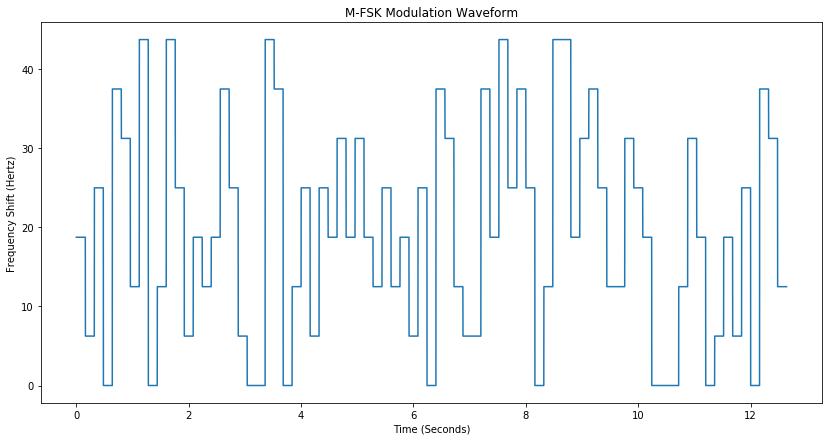

In [6]:
mfsk_example()

## Gaussian Shaping

WSJT-X 2.1 modified the modulation method used by FT8 from M-ary frequency shift keying (M-FSK) to
M-ary gaussian frequency shift keying (M-GFSK), where M = 8.

M-GFSK is implemented by filtering the M-FSK stepped modulation waveform with a gaussian filter prior
to modulation.
A gaussian filter is a filter with the gaussian function as the impulse response:

$$G(t) = \frac{1}{\sigma \sqrt{2 \pi}} e^{-\frac{t^2}{2 \sigma^2}}$$

The 3dB bandwidth $B$ of the gaussian filter is given by the expression:

$$B = \frac{\sqrt{\ln{2}}}{2\pi\sigma}$$

and therefore:

$$\sigma = \frac{\sqrt{\ln{2}}}{2\pi B}$$

In WSJT-X the Gaussian filter is implemented by considering each symbol in the modulation waveform
as a separate pulse.
The modulation waveform is then obtained by summing the gaussian filtered pulses corresponding to each symbol.
As the pulse corresponding to each symbol is the same basic shape (a boxcar function),
the gaussian filtered pulse shape only needs to be calculated once for a particular sample rate and baud rate.
It can then be scaled and shifted in time to obtain the gaussian filtered pulse corresponding to each symbol.

The gaussian filtered pulse is the convolution of the boxcar function with the gaussian function, which can
be expressed as an integral of the gaussian function:

$$p(t) = \frac{1}{\sigma \sqrt{2 \pi}} \int_{t-0.5}^{t+0.5} e^{-\frac{t^2}{2 \sigma^2}}$$
If we let:

$$c = \frac{1}{\sqrt{2}\sigma} = \frac{2 \pi B}{\sqrt{2}.\sqrt{\ln{2}}} = B\pi\sqrt{\frac{2}{\ln{2}}}$$

we get:

$$p(t) = \frac{c}{\sqrt{\pi}}\int_{t-0.5}^{t+0.5}e^{-c^2t^2}dx = \frac{1}{2}(\textrm{erf}(c(t+0.5)-\textrm{erf}(c(t-0.5))$$

The error function is available in the Python `scipy.special` library.

In [7]:
def gaussian_boxcar(b, t):
    """Function to calculate gaussian filtered boxcar pulse waveform to perform M-GFSK modulation.
    
    The boxcar function is assumed to be centered around t = 0 with width 1.0 and amplitude 1.0.
    This function will return the value of the gaussian filtered boxcar at time t.
    The parameter t can be a scalar or a numpy array.
    The parameter b controls the bandwidth of the gaussian filter."""
    c = b * np.pi * np.sqrt(2.0 / np.log(2.0))
    return 0.5 * (scipy.special.erf(c * (t + 0.5)) - scipy.special.erf(c * (t - 0.5)))

The following example code calculates a gaussian filtered boxcar pulse.

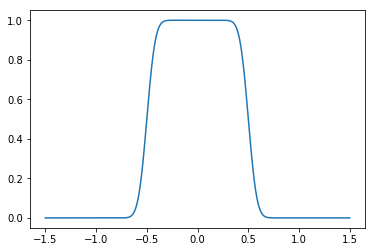

In [8]:
samples_per_symbol = 512
bandwidth = 2.0 # FT8 uses a bandwidth that is twice the baud rate
t = np.linspace(-1.5, 1.5, 3 * samples_per_symbol, endpoint=False)
filtered_boxcar = gaussian_boxcar(bandwidth, t)
plt.plot(t, filtered_boxcar)

The following function constructs a modulation waveform by adding gaussian filtered boxcar pulses that are
scaled and time shifted for each symbol.

In [9]:
def modulation_waveform(symbols, samples_per_symbol, pulse):
    """Generate a modulation waveform from a list of symbols using the provided pulse waveform
    
    The pulse waveform must have a length that is equal to three symbol periods."""
    
    assert pulse.size == 3 * samples_per_symbol
    w = np.zeros((len(symbols) + 4) * samples_per_symbol)
    s = 0
    
    # Pad start and end of waveform with first and last symbol respectively
    for symbol in ([symbols[0]] + symbols + [symbols[-1]]):
        w[s: s + pulse.size] += symbol * pulse
        s += samples_per_symbol

    return w[samples_per_symbol * 2: samples_per_symbol * (2 + len(symbols))]

The difference between the M-FSK and M-GFSK modulation waveforms is illustrated below:

In [10]:
def mfsk_mgfsk_difference_example():
    plt.figure(figsize = (14,7))
    
    duration = 2.0
    symbol_count = duration * ft8.baud_rate
    samples = int(samples_per_symbol * symbol_count)
    t = np.linspace(0, 2, samples)
    
    ax1 = plt.subplot(121)
    ax1.set(xlabel='Time (Seconds)', ylabel='Frequency Shift (Hertz)')
    ax1.set_title('M-FSK Modulation Waveform')
    plt.plot(t, mfsk_modulation[:samples])
    
    ax2 = plt.subplot(122)
    ax2.set(xlabel='Time (Seconds)', ylabel='Frequency Shift (Hertz)')
    ax2.set_title('M-GFSK Modulation Waveform')
    plt.plot(t, modulation_waveform(symbols, samples_per_symbol, filtered_boxcar)[:samples] * ft8.freq_shift)

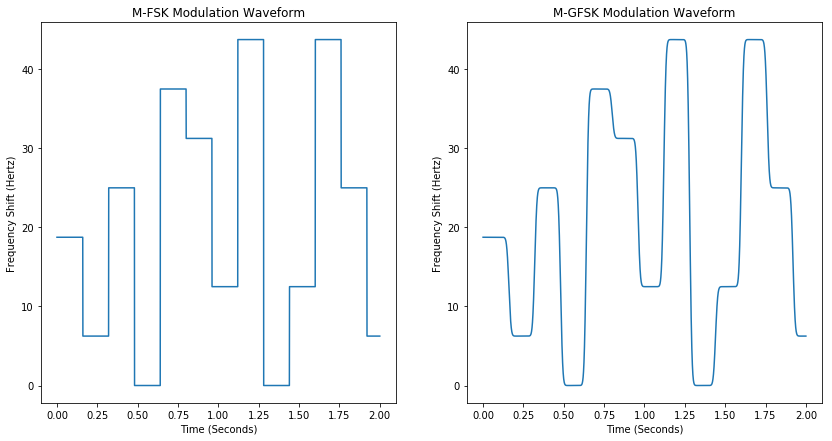

In [11]:
mfsk_mgfsk_difference_example()

## Frequency Modulation

Once a gaussian filtered modulation waveform can be constructed from a list of symbols, we can use
this to frequency modulate a carrier frequency to get M-GFSK.

The following function performs frequency modulation of a carrier using a gaussian filtered modulation waveform
that has been constructed from a list of symbols.

The modulation can be offset in time to simulate transmit and receive clocks that do not precisely align with
UTC.

This function requires a pre-calculated gaussian filtered boxcar pulse to be provided.

In [12]:
def mgfsk(if_freq, offset, symbols, pulse, sample_rate = 12000):
    """Synthesize M-GFSK modulated carrier
    
    if_freq - Carrier frequency in Hz
    offset - Time offset in seconds
    symbols - Encoded message symbols
    pulse - Symbol pulse waveform
    sample_rate - Sample rate in Hz"""
    
    # Derived constants
    two_pi = 2.0 * np.pi
    samples_per_symbol = int(sample_rate / ft8.baud_rate)
    total_samples = ft8.tr_period * sample_rate
    cycle = 2.0 * np.pi / sample_rate
    dphase_symbol = cycle * ft8.freq_shift
    dphase_if_freq = cycle * if_freq
    
    # Calculate signal phases
    phases = np.zeros(total_samples)
    phase = 0
    sample = int(sample_rate * (ft8.start_delay + offset))
    mod_wave = modulation_waveform(symbols, samples_per_symbol, pulse)
    dphases = mod_wave * dphase_symbol + dphase_if_freq       
    for dphase in dphases:      
        phase += dphase
        phase %= two_pi
        phases[sample] = phase    
        sample += 1

    # TBD amplitude shaping
    
    # TBD complex signal
    
    return np.sin(phases)

In [13]:
def mgfsk_example():
    plt.figure(figsize = (14,7))
    
    # Calculate the gaussian filtered boxcar pulse
    duration = 1.5
    symbol_count = duration * ft8.baud_rate
    samples = int(samples_per_symbol * symbol_count)
    t = np.linspace(0, duration, samples)
    
    # Other parameters
    base_freq = 10
    
    # Plot modulation waveform
    ax1 = plt.subplot(121)
    ax1.set(xlabel='Time (Seconds)', ylabel='Frequency Shift (Hertz)')
    ax1.set_title('Modulation Waveform')
    plt.plot(t, modulation_waveform(symbols, samples_per_symbol, filtered_boxcar)[:samples] * ft8.freq_shift)
    
    # Plot frequency modulated waveform
    ax2 = plt.subplot(122)
    ax2.set(xlabel='Time (Seconds)', ylabel='Volts')
    ax2.set_title('Frequency Modulated Carrier')
    plt.plot(t, mgfsk(10, -0.5, symbols, filtered_boxcar, int(ft8.baud_rate * samples_per_symbol))[:samples]) 

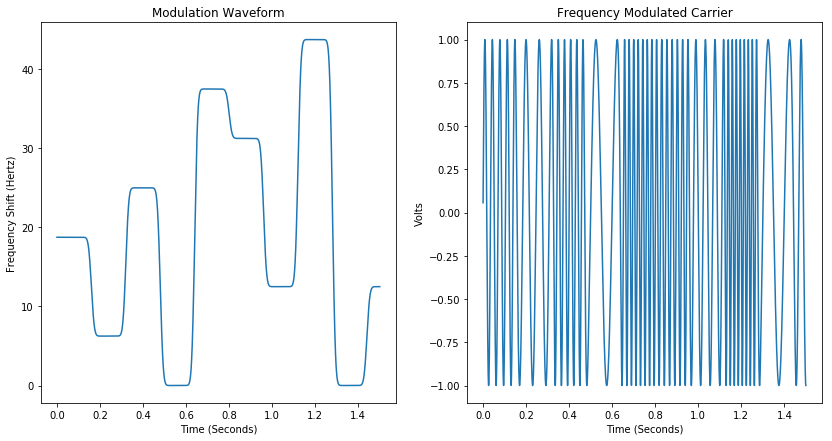

In [14]:
mgfsk_example()

## Receiver Passband Simulation

We now have all the elements needed to simulate a receiver passband full of FT8 signals.

The following function generates M-GFSK modulated carriers for multiple FT8 signals and combines them with
additive gaussian white noise (AGWN).
The result is saved in a WAV file suitable for use with WSJT-X.

Each FT8 signal is specified using a tuple comprised of:
* Message
* Intermediate carrier frequency
* Time offset to apply to the start of the modulation - this should be between -0.5 and +0.5 seconds.
* Desired signal to noise ratio for this signal

The signal to noise ratio and noise power use the same scale as the WSJT-X decoder:
* Clipping occurs when the transmit power exceeds approximately 90dB (assuming no noise).
* The default noise power of 30dB matches what is suggested by the WSJT-X GUI.

In [15]:
def simulate(signals, filename, noise_db = 30.0, sample_rate = 12000):
    """Simulate a passband containing multiple FT8 signals and noise"""
    # signals is a list of signal tuples
    # filename is the desired name for the WAV file - samples are in a 16-bit signed mono format
    # noise_power is the noise power in dB - note that noise is not added when noise_power is zero.
    # sample_rate is the desired sample rate for the WAV file
   
    # Derived constants
    samples_per_symbol = int(sample_rate / ft8.baud_rate)
    total_samples = sample_rate * ft8.tr_period

    # Calculate noise standard deviation and power
    noise_sigma = 10.0**(noise_db / 20)
    noise_power = 2500 / sample_rate * 2 * noise_sigma * noise_sigma  # Noise power in 2.5kHz
    
    # Calculate the gaussian filtered boxcar pulse
    t = np.linspace(-1.5, 1.5, 3 * samples_per_symbol, endpoint=False)
    filtered_boxcar = gaussian_boxcar(ft8.gaussian_bandwidth, t)
    
    # Start with some Gaussian noise
    samples = np.random.normal(0, noise_sigma, total_samples)
    
    # Process each signal
    for message, if_freq, snr, offset in signals:
            
        # Calculate signal amplitude
        tx_power = noise_power * 10 ** (snr / 10) # SNR is relative to noise in 2.5kHz bandwidth
        amplitude = np.sqrt(2 * tx_power)
        
        # Encode the message
        symbols = message.encode()
        
        # Add signal into the mix
        samples += amplitude * mgfsk(if_freq, offset, symbols, filtered_boxcar, sample_rate)
    
    # Convert floating point samples to 16-bit integer
    samples.round()
    wavedata = samples.astype('int16')
    
    # Write to WAV file
    scipy.io.wavfile.write(filename, sample_rate, wavedata)
    
    return wavedata

### Notes

1. The TX SNR corresponds well with WSJT-X in the range -19dB to 3dB.
For TX SNR > 3dB, the value reported by WSJT-X starts to diverge (the reported value is lower than the actual
value).
1. The noise dB corresponds well with that reported by the WSJT-X signal meter inside the "green range" of
20dB to 80dB.
1. Values for dt corresponds well with WSJT-X reported value.


In [16]:
signals = [
    (ft8.StandardMessage(ft8.Callsign('VK3JPK'), ft8.Callsign('K1JT'), ft8.LocationReport('QF22')), 1500, 0, 0.4),
    (ft8.StandardMessage(ft8.Callsign('VK1ABC'), ft8.Callsign('VK2DEF'), ft8.SignalReport(-12)), 1200, -10, 0.3)
]
wavedata = simulate(signals, 'audio/simulate.wav', noise_db = 30)

Total power = 31.4 dB
Noise Power in 6000 Hz = 29.9
Noise Power in 2500 Hz = 26.1
Noise Power in 50 Hz = 9.1
TX Power at 1200 is 16.2 dB
SNR_2500 = -9.9 dB
SNR_6.25 = 16.1 dB
TX Power at 1500 is 26.2 dB
SNR_2500 = 0.1 dB
SNR_6.25 = 26.1 dB


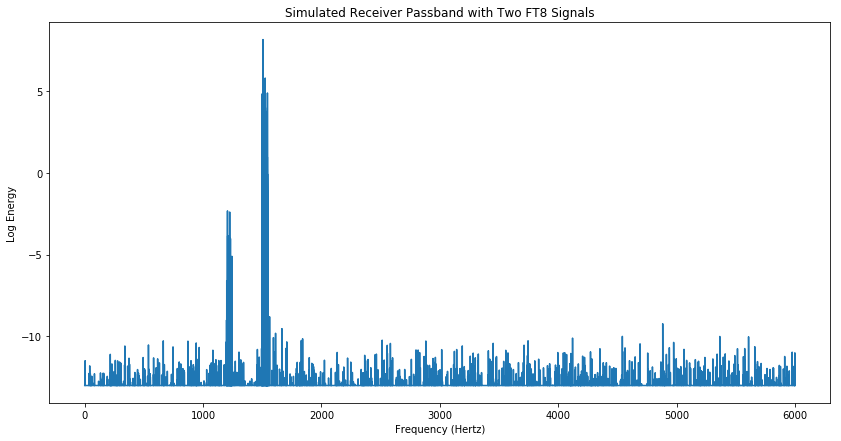

In [17]:
# Calculate power in frequency domain
real_fft = np.fft.rfft(wavedata)
power_spectrum = 2*(np.abs(real_fft[1:])/wavedata.size)**2
total_power = np.sum(power_spectrum)
print("Total power = {0:.1f} dB".format(10*np.log10(total_power)))
noise_power = 50/1000 * np.sum(power_spectrum[-15000:]) # Get estimate of noise power in signal bandwidth
print("Noise Power in 6000 Hz = {0:.1f}".format(10*np.log10(noise_power * 6000/50)))
print("Noise Power in 2500 Hz = {0:.1f}".format(10*np.log10(noise_power * 2500/50)))
print("Noise Power in 50 Hz = {0:.1f}".format(10*np.log10(noise_power)))

# Calculate signal power and snr
for f in [1200, 1500]:
    low_bin = int((f-3.125)/6000 * 90000)
    high_bin = low_bin + int(8 * 6.25/6000 * 90000)
    tx_power =  np.sum(power_spectrum[low_bin-1:high_bin]) # Power in nominal bandwidth of signal
    tx_power -= noise_power # Adjust tx_power to remove noise_power
    # The following fudge factor corrects for:
    # a) Not all TX power residing in the nominal signal bandwidth of 50 Hz.
    # b) TX is only active for 12.64 seconds out of the 15 second signal record
    tx_power *= 1.207
    print("TX Power at {0} is {1:.1f} dB".format(f, 10*np.log10(tx_power)))
    # Calculate SNR
    snr_2500 = tx_power / (noise_power * 50)
    snr_6 = tx_power / (noise_power / 8)
    print("SNR_2500 = {0:.1f} dB".format(10*np.log10(snr_2500)))
    print("SNR_6.25 = {0:.1f} dB".format(10*np.log10(snr_6)))

# Plot the spectrum
plt.figure(figsize = (14,7))
plt.xlabel("Frequency (Hertz)")
plt.ylabel("Log Energy")
plt.title("Simulated Receiver Passband with Two FT8 Signals")
plt.plot((np.fft.rfftfreq(wavedata.size)*12000)[1:], 10*np.log10(np.clip(power_spectrum, 0.05, None)))

## License
Copyright (C) 2019 James Kelly, VK3JPK.

<a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-sa/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/">Creative Commons Attribution-ShareAlike 4.0 International License</a>.